# Exploiting Structure in Data

In [1]:
%matplotlib inline
import numpy as np
import pandas
from plotnine import *
import sys
sys.path.append('..')
from plotting import plot_linear_classifier
from plotting import plot_classifier
from plotting import plot_sample

/home/welbergenh/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def euler_dist(U):
    dist = np.zeros(len(U))
    idx = 0
    for _, x in U.iterrows():
        dist[idx] = (((U-x)*(U-x)).sum(axis=1).pow(0.5).sum())/len(U)
        idx = idx+1  
    return dist

In [3]:
def uncertainty(U, model):
    return -np.abs(model.predict_proba(U)[:,1]-0.5)

In [4]:
def active_learn(num_samples, initial_sample, data, model, beta = 0):
    sample = initial_sample
    labeled = sample.index    
    unlabeled = data.index[~data.index.isin(sample.index)]
    for i in range(0, num_samples+1):
        sample = data.loc[labeled]
        X = sample[['x','y']]
        y = sample.label
        model.fit(X,y)
        U = data.loc[unlabeled]    
        xstar_index = np.argmax(U.dist.pow(beta) * uncertainty(U[['x','y']], model))
        labeled = labeled.insert(0,xstar_index)
        unlabeled = unlabeled.drop(xstar_index)
    return sample

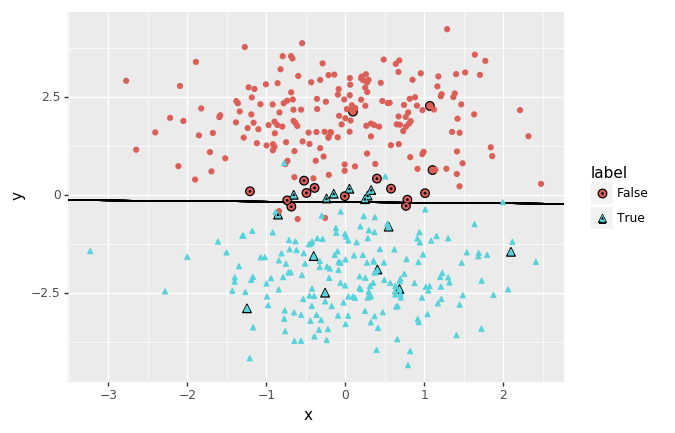

<ggplot: (8774712615358)>

In [5]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
data = pandas.read_pickle('../data/two_2dgaussians.pkl')
data['dist'] = euler_dist(data[['x','y']])
initial_sample = data.sample(10)
sample = active_learn(20, initial_sample, data, lg, beta = 10)

labeled_initial = initial_sample.index
selected = data.loc[sample.index.difference(labeled_initial)]
plot_linear_classifier(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Density weighting with outliers

### Without density weights

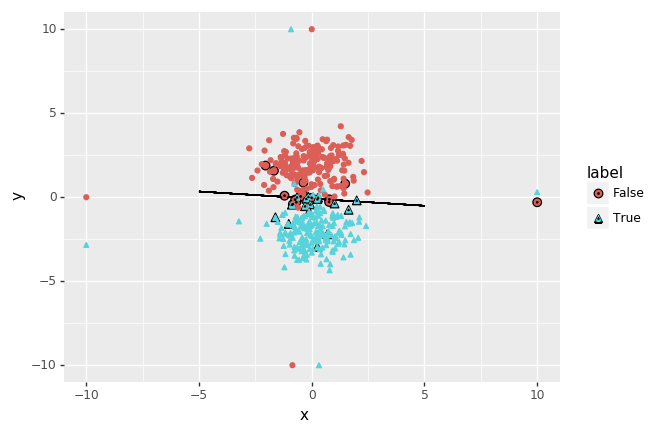

<ggplot: (8774702942051)>

In [43]:
data = pandas.read_pickle('../data/two_2dgaussians_with_outliers.pkl')
data['dist'] = euler_dist(data[['x','y']])
initial_sample = data.sample(10)
sample = active_learn(20, initial_sample, data, lg, beta=0)

labeled_initial = initial_sample.index
selected = data.loc[sample.index.difference(labeled_initial)]
plot_linear_classifier(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

### With density weights

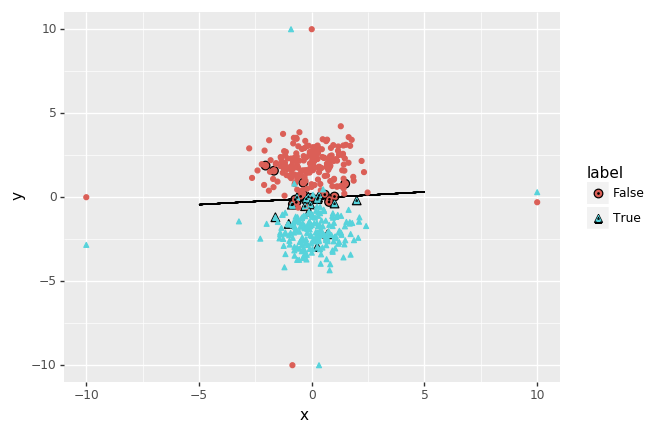

<ggplot: (8774703023101)>

In [50]:
sample = active_learn(20, initial_sample, data, lg, beta=10)
labeled_initial = initial_sample.index
selected = data.loc[sample.index.difference(labeled_initial)]
plot_linear_classifier(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

### Density weighting, skewed data

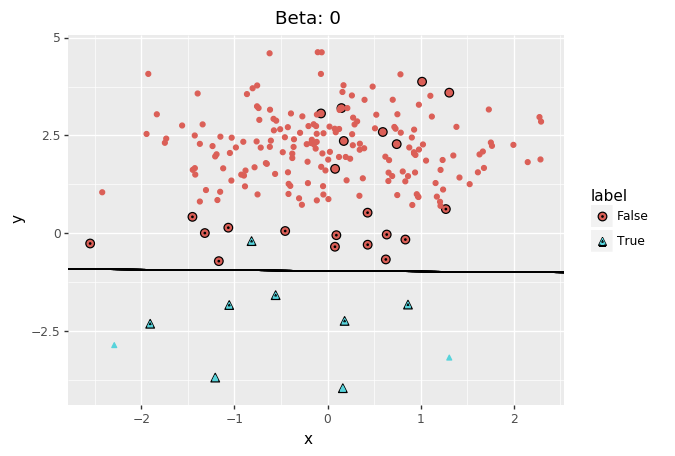

<ggplot: (8774702974384)>


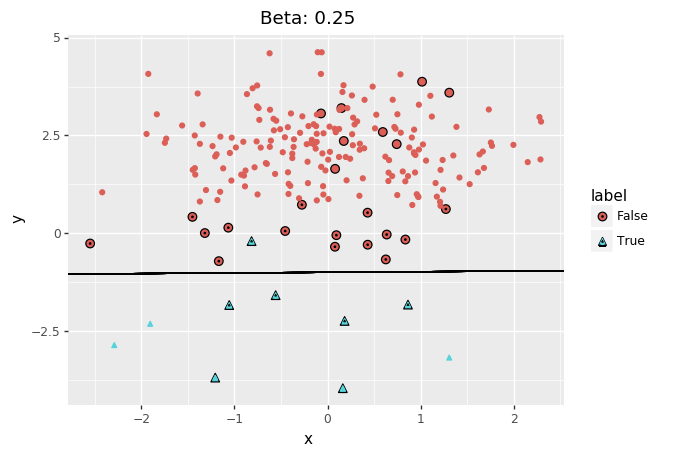

<ggplot: (8774702730062)>


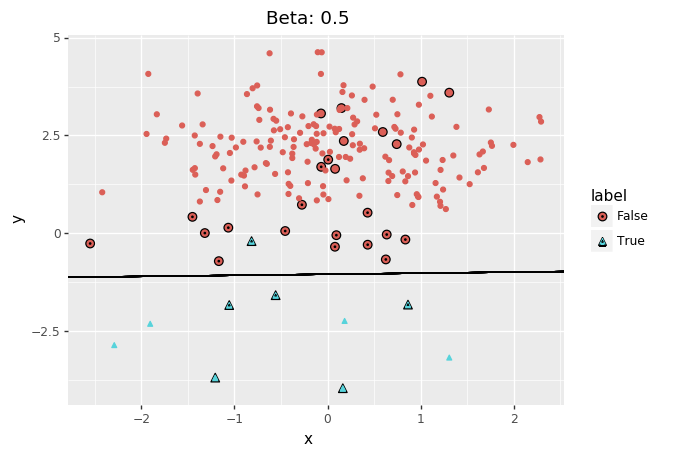

<ggplot: (-9223363262152068636)>


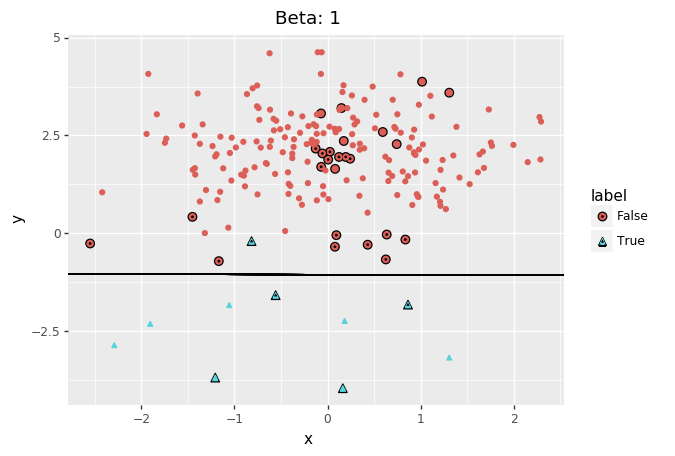

<ggplot: (8774709343801)>


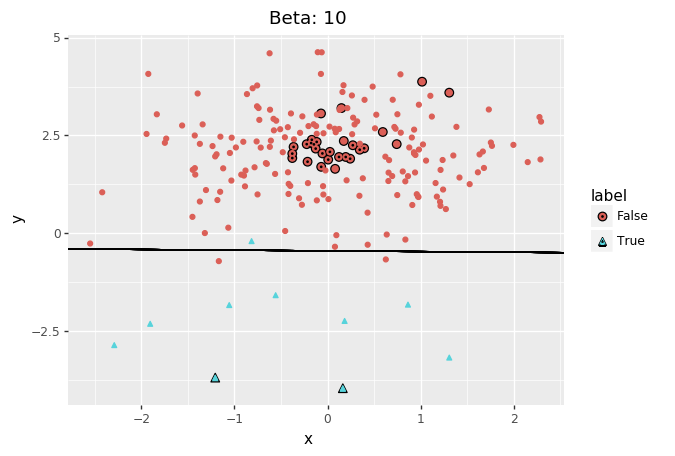

<ggplot: (8774685090582)>


In [67]:
data = pandas.read_pickle('../data/two_2dgaussians_skewed.pkl')
data['dist'] = euler_dist(data[['x','y']])
initial_sample = data[data.label==True].sample(1)
initial_sample = initial_sample.append(data.sample(9))

for beta in [0, 0.25, 0.5, 1, 10]:
    sample = active_learn(20, initial_sample, data, lg, beta=beta)
    labeled_initial = initial_sample.index
    selected = data.loc[sample.index.difference(labeled_initial)]
    print(plot_linear_classifier(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)+\
          ggtitle("Beta: "+str(beta)))

## Density weighting with input bias

In [8]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier(n_estimators=100, max_features=2)    

In [9]:
data = pandas.read_pickle('../data/three_2dgaussians.pkl')
data['dist'] = euler_dist(data[['x','y']])

### Initial model

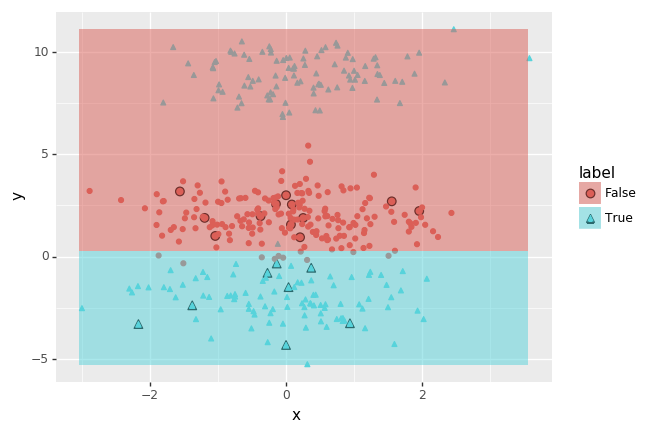

<ggplot: (-9223363262151562054)>

In [10]:
initial_sample = data[data.y<5].sample(20)
labeled_initial = initial_sample.index
X = initial_sample[['x','y']]
y = initial_sample.label
tree.fit(X,y)
plot_classifier(initial_sample, data, tree)

### No clustering

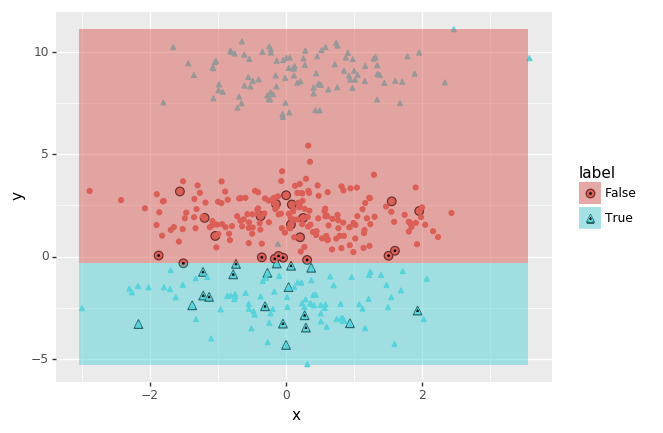

<ggplot: (8774703213611)>

In [11]:
sample = active_learn(20, initial_sample, data, tree)
selected = data.loc[sample.index.difference(labeled_initial)]
plot_classifier(sample, data, tree)+geom_point(selected,aes(x='x',y='y'), size=0.1)

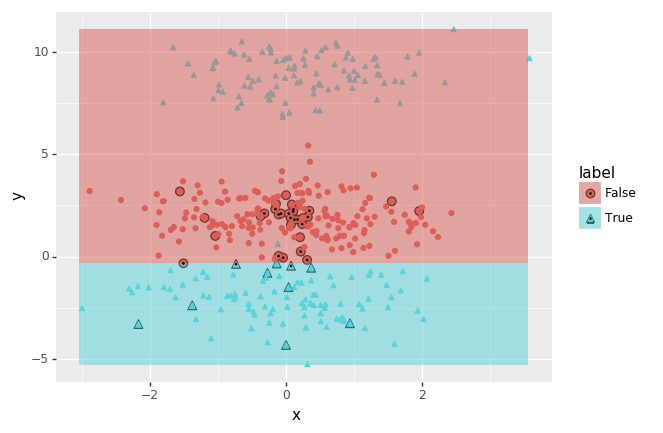

<ggplot: (8774705638376)>

In [12]:
sample = active_learn(20, initial_sample, data, tree, beta=0.5)
selected = data.loc[sample.index.difference(labeled_initial)]
plot_classifier(sample, data, tree)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Cluster-based active learning

In [13]:
from scipy.cluster.hierarchy import *

In [14]:
data = pandas.read_pickle('../data/two_2dgaussians.pkl')
Z = linkage(data[['x','y']], 'ward')

In [15]:
tree = to_tree(Z)
tree.get_count()

400

In [16]:
def get_data_points(cluster_node):
    if cluster_node.is_leaf():
        return [cluster_node.get_id()]
    else:
        left = get_data_points(cluster_node.get_left())
        right = get_data_points(cluster_node.get_right())
        return left+right

In [17]:
clustered_data = data.copy()

In [18]:
clustered_data['cluster'] = None
clustered_data.loc[get_data_points(tree.get_left()), 'cluster'] = 1
clustered_data.loc[get_data_points(tree.get_right()), 'cluster'] = 2

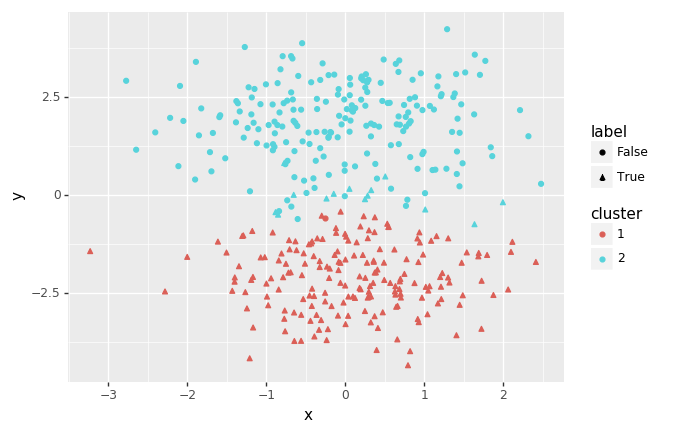

<ggplot: (-9223363262145389224)>

In [19]:
ggplot(clustered_data, aes(x='x', y='y', shape='label', color='cluster'))+geom_point()

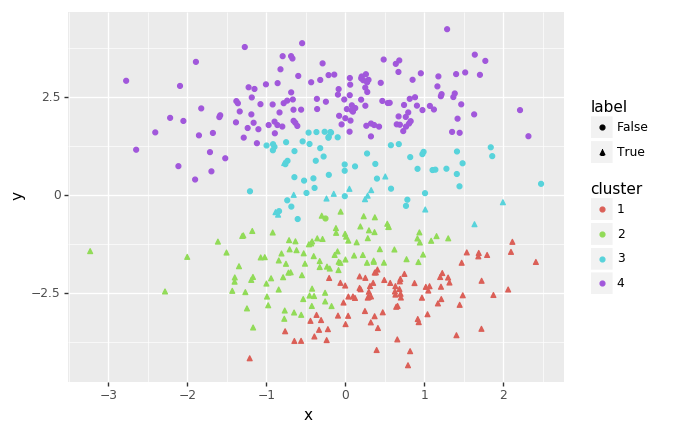

<ggplot: (-9223363262169685907)>

In [20]:
clustered_data.loc[get_data_points(tree.get_left().get_left()), 'cluster'] = 1
clustered_data.loc[get_data_points(tree.get_left().get_right()), 'cluster'] = 2
clustered_data.loc[get_data_points(tree.get_right().get_left()), 'cluster'] = 3
clustered_data.loc[get_data_points(tree.get_right().get_right()), 'cluster'] = 4
ggplot(clustered_data, aes(x='x', y='y', shape='label', color='cluster'))+geom_point()

In [34]:
import random
def aktive_learn(data, num_samples):
    Z = linkage(data[['x','y']], 'ward')
    tree = to_tree(Z)
    P = [tree.get_left(), tree.get_right()]
    U = data[['x','y']]
    U['label'] = None
    for _ in range(0,num_samples):        
        max_score = 0
        vMax = P[0]        
        for v in P:            
            labels = U.loc[get_data_points(v),'label']
            score = float(len(labels))            
            m = labels.mode()
            if len(m)>0:
                vLabel = m[0]                   
                #s = (1.0-float(sum(labels==vLabel))/float(sum(~labels.isnull())))
                s = (1.0-float(sum(labels==vLabel))/float(len(labels)))
                #s = s+random.random()*0.0001
                score = score * s
                #print(str(vLabel)+' score:'+str(score)+' s:'+str(s))
            #else:
            #    score = len(U)
                
            if score>max_score:
                vMax = v
                max_score = score
            
        Usel = U.loc[get_data_points(vMax)]
        sample_idx = Usel.label.isnull().sample(1).index
        U.loc[sample_idx, 'label'] = data.loc[sample_idx, 'label']
        labels_max = U.loc[get_data_points(vMax),'label']
        if vMax.get_count()>2:# and True in labels_max and False in labels_max:
            P = list(filter(lambda v: v!=vMax, P))
            P = P + [vMax.get_left(), vMax.get_right()]            
    return U.dropna()
                

### Active learning

In [22]:
data = pandas.read_pickle('../data/two_2dgaussians.pkl')
sample = aktive_learn(data, 30)

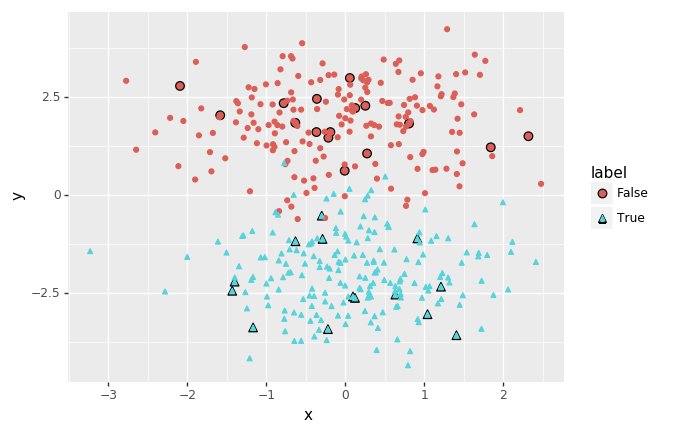

<ggplot: (8774709362685)>

In [23]:
plot_sample(sample,data)

### Random sampling

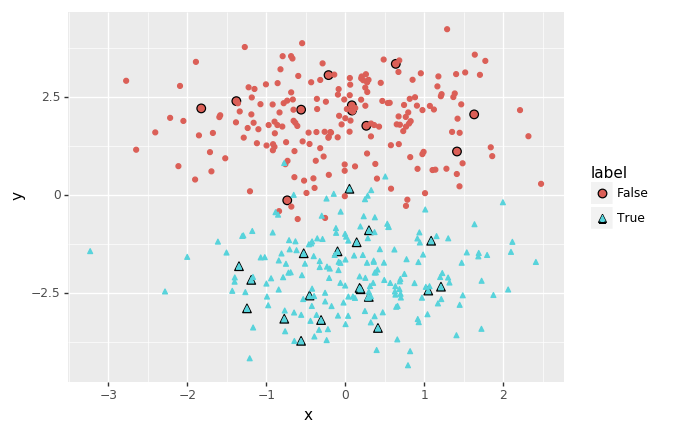

<ggplot: (-9223363262145376417)>

In [24]:
plot_sample(data.sample(30),data)

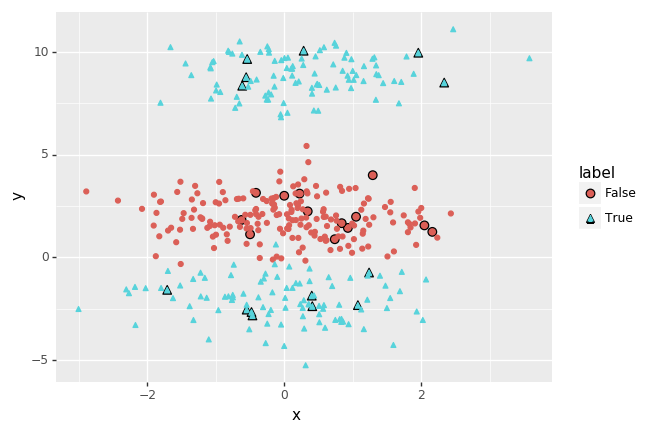

<ggplot: (-9223363262138991886)>

In [25]:
data = pandas.read_pickle('../data/three_2dgaussians.pkl')
sample = aktive_learn(data, 30)
plot_sample(sample,data)

### Multiple labels, multiple groups
Cluster based active learning seems to help most when there are multiple clusters in the data and several labels.

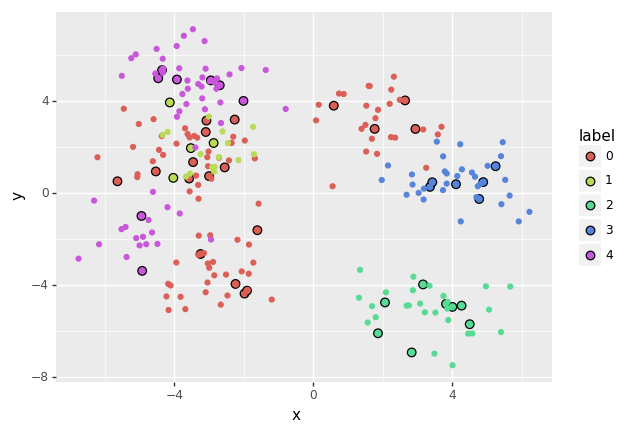

<ggplot: (8774702960974)>

In [26]:
data = pandas.read_pickle('../data/lots_of_gaussians.pkl')
sample = aktive_learn(data, 50)
ggplot(sample, aes(x='x', y='y', fill='label'))+\
            geom_point(size=3)+\
            geom_point(data, aes(x='x',y='y',color='label'))

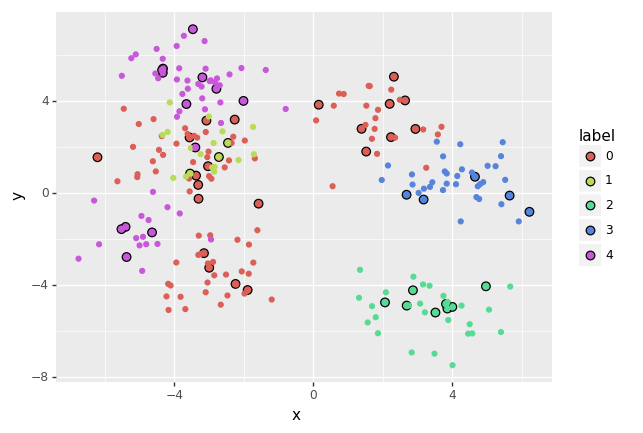

<ggplot: (-9223363262151920489)>

In [27]:
sample = data.sample(50)
ggplot(sample, aes(x='x', y='y', fill='label'))+\
            geom_point(size=3)+\
            geom_point(data, aes(x='x',y='y',color='label'))

## Cluster based learning, skewed data

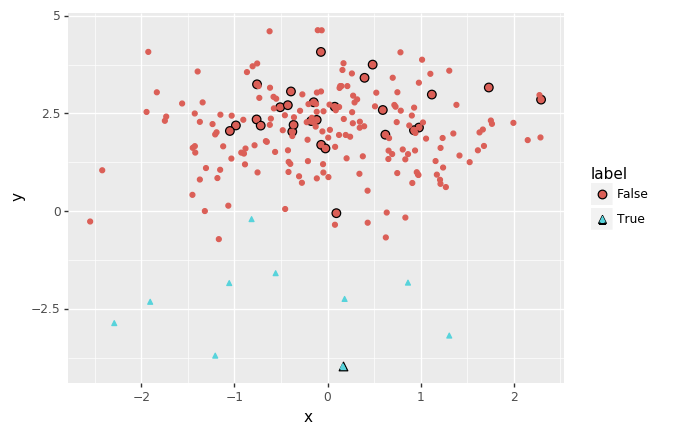

<ggplot: (8774703944968)>

In [35]:
data = pandas.read_pickle('../data/two_2dgaussians_skewed.pkl')
sample = aktive_learn(data, 30)
plot_sample(sample,data)